In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
import datetime

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import torch
from torch import nn

def forma(x):
    x = [float(i.replace(',','.')) for i in  x.values]
    return x

def scale(x):
    x_mean = np.mean(x)
    x_std  = np.std(x)
    x_scaled = (x - x_mean)/x_std
    return x_scaled

def norm_scale(x):
    min = np.min(x)
    max = np.max(x)
    x_scaled = (x - min) / (max - min)
    return x_scaled

In [2]:
df = pd.read_csv(r"Compare_ACE_DSCOVR.csv", sep=';')

df['B_x'] = df.shift(periods=21, fill_value=np.nan)['B_x']
df['B_gsm_y'] = df.shift(periods=11, fill_value=np.nan)['B_gsm_y']
df['B_gsm_z'] = df.shift(periods=3, fill_value=np.nan)['B_gsm_z']
df['B_magn'] = df.shift(periods=14, fill_value=np.nan)['B_magn']
df['H_den_SWP'] = df.shift(periods=10, fill_value=np.nan)['H_den_SWP']
df['SW_spd'] = df.shift(periods=55, fill_value=np.nan)['SW_spd']

values = ['B_x', 'B_gsm_y', 'B_gsm_z', 'B_magn', 'H_den_SWP', 'SW_spd']

for elem in values:
    df = df.drop(df[df[elem] == 'N'].index)
    df = df.dropna()

for elem in values:
    data = forma(df[elem])
    df[elem] = data

# for elem in values:
#     data = norm_scale(df_new[elem])
#     df[elem] = data

In [9]:
new_values = ['Dst',] + values

date_values = ['year', 'month', 'day', 'hour from']
date = pd.DataFrame(df.loc[:, date_values])

date['hour from'] = date['hour from'].map(lambda x: '0'+str(x) if x not in range(10, 24) else str(x))
date['datetime'] = date['year'].astype(str) + date['month'].astype(str) + date['day'].astype(str) + ' ' + date['hour from']
date['datetime'] = pd.to_datetime(date['datetime'])

dataset = pd.DataFrame({elem:df[elem] for elem in new_values})
dataset = dataset.set_index(date['datetime'])

In [17]:
if not dataset.index.is_monotonic_increasing:
   dataset = dataset.sort_index()

x_train = dataset[values][:'2019-01-01 01:00:00']
x_test = dataset[values]['2019-01-01 01:00:00':]
y_train = dataset['Dst'].loc[:'2019-01-01 01:00:00']
y_test = dataset['Dst'].loc['2019-01-01 01:00:00':]

pipe = make_pipeline(MinMaxScaler(), LinearRegression())
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
print('y_predicted:', y_pred)

R_2 = metrics.r2_score(y_test, y_pred)
MSE = metrics.mean_squared_error(y_test, y_pred)
MAE = metrics.mean_absolute_error(y_test, y_pred)

print('R**2 score:', R_2)
print('MSE:', MSE)
print('MAE:', MAE)

y_predicted: [ -5.44528569  -7.93173413 -13.30439374 ...  -6.38882899 -12.49931618
  -9.2694199 ]
R**2 score: 0.1910455533090838
MSE: 94.41588386898364
MAE: 7.083373965088207


In [11]:
# x_train = dataset[values][:'2019-01-01 01:00:00']
# x_test = dataset[values]['2019-01-01 01:00:00':]
# y_train = dataset['Dst'].loc[:'2019-01-01 01:00:00']
# y_test = dataset['Dst'].loc['2019-01-01 01:00:00':]

# # x_train= x_train.reshape(-1, 1)
# # x_test = x_test.reshape(-1, 1)

# model = linear_model.LinearRegression()
# model.fit(x_train, y_train)
# print('Coefficients:', model.coef_)
# print('Intercept:', model.intercept_)
# print()

# y_pred = model.predict(x_test)

# print('R**2 score:', metrics.r2_score(y_test, y_pred))
# print('MSE:', metrics.mean_squared_error(y_test, y_pred))
# print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

Coefficients: [-0.00888798 -0.09930079  2.65468997 -3.14185488 -0.05372597 -0.04376281]
Intercept: 25.37303277931504

R**2 score: 0.19104555330908413
MSE: 94.4158838689836
MAE: 7.083373965088219


Text(0, 0.5, 'MSE, нТл')

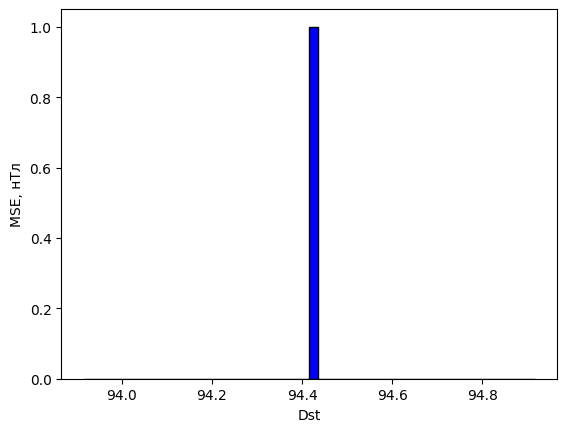

In [21]:
plt.hist(MSE, color = 'blue', edgecolor = 'black',
         bins = 50)

plt.xlabel('Dst')
plt.ylabel('MSE, нТл')

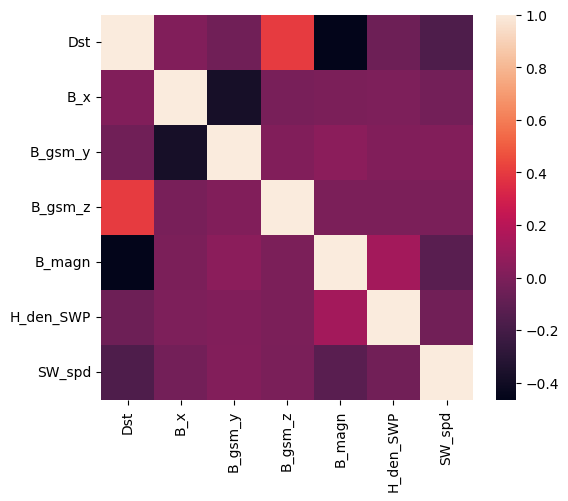

In [18]:
corr_matrix = dataset.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix)
plt.show()